# MAPIE - Regression Task
### Complete example for testing the coverage validity and adaptability

The aim of this notebook is to carry out a complete example on the regression task in order to :
- explore the features available in MAPIE
- visualise the empirical distribution of non-conformity scores
- visualise the empirical distribution of prediction set sizes
- visualise their correlation with and between predictions and labels
- visualise the impact of the choice of risk level (and confidence level) on effective coverage and average prediction set size
- visualise the empirical distribution of effective coverage
- see that the marginal coverage guarantee is valid in MAPIE

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy, deepcopy

import warnings
warnings.filterwarnings("ignore")

from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE

np.random.seed(32)

### 1) Obtain data and split it into train, calibration and validation datasets

In [2]:
from datasets import load_dataset
from utils.data.auto_mpg import sample_and_split_dataset, get_dataframe, get_X_y
#from utils.data.auto_mpg import get_label_mapping, transform_set_to_label
from utils.data.auto_mpg import FEATURES, LABEL, TARGET, PREDICTION, SET, SET_LABEL


nb_train, nb_calib, nb_valid = 120, 50, 50

dataset = load_dataset("scikit-learn/auto-mpg")
ds_train, ds_calib, ds_valid = sample_and_split_dataset(dataset, nb_train=nb_train, nb_calib=nb_calib, nb_test=nb_valid)
df_train, df_calib, df_valid = get_dataframe(ds_train, ds_calib, ds_valid)
(X_train, y_train), (X_calib, y_calib), (X_valid, y_valid) = get_X_y(df_train, df_calib, df_valid)

Using the latest cached version of the dataset since scikit-learn/auto-mpg couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/thibaultcordier/.cache/huggingface/datasets/scikit-learn___auto-mpg/default/0.0.0/5df91be3ec941e3ce0e9e214d0be2d208bcb6b05 (last modified on Fri Sep  6 18:05:25 2024).


### 2) View data (pairplot)

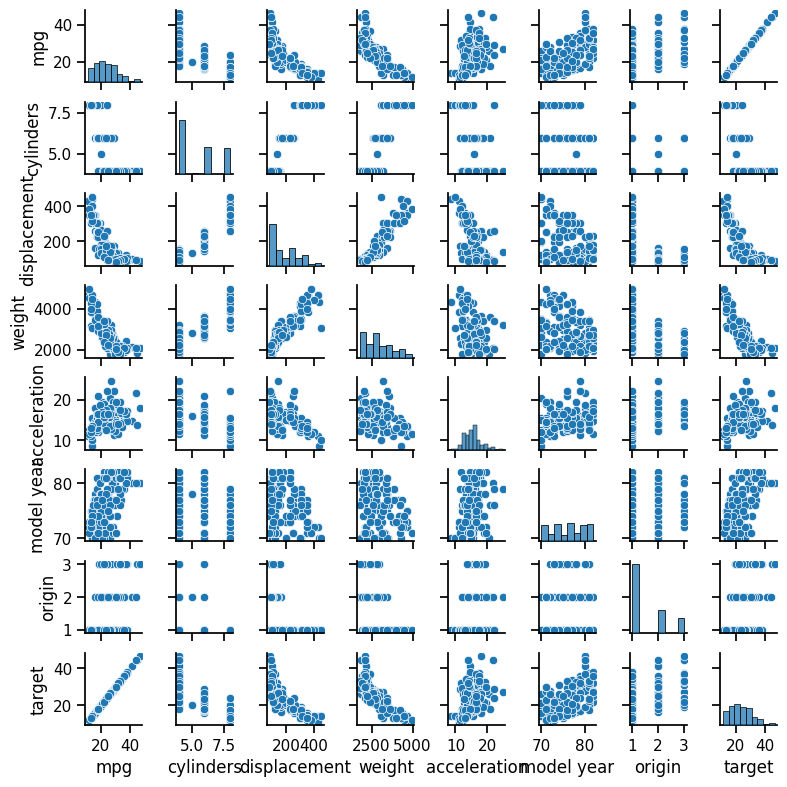

In [3]:
from utils.data.auto_mpg import plot_data

# Plot the data in 2D (pair plot).
plot_data(df_train, figsize=SMALL_FIGSIZE)

***
## MAPIE: model training, calibration and prediction (MAPIE/scikit-learn compatible routine)
### 3) Run the 4 steps of the MAPIE routine

The MAPIE routine is composed of 4 steps:
1. Identify a (pre-trained) model.
2. Wrap it with the MAPIE class:
   - Choose the non-conformity score.
   - and compute conformity scores on calibration data.
3. Predict the target on the test data to obtain the prediction sets.

This routine is comparable to that of any scikit-learn-compatible estimator.

In [4]:
import numpy as np
from mapie.regression import MapieRegressor
from mapie.conformity_scores import AbsoluteConformityScore
from sklearn.ensemble import RandomForestRegressor


# 1) Get main predictor.
kwargs_predictor={}
rgr = RandomForestRegressor(**kwargs_predictor)
rgr = rgr.fit(X_train, y_train)

# 2) Get the non-conformity score.
kwargs_score={}
csf = AbsoluteConformityScore(**kwargs_score)

# 3) Conformalize the main predictor (wrap with MAPIE conformal class).
kwargs_conformalizer={'conformity_score': csf, 'cv': 'prefit'}  # split conformal setting
mapie_regressor = MapieRegressor(estimator=rgr, **kwargs_conformalizer)
mapie_regressor = mapie_regressor.fit(X_calib, y_calib)

# 4) Obtain predictions and prediction sets.
alpha_list = np.linspace(0.1, 0.9, 101)
kwargs_predict = {}
y_pred, y_pis = mapie_regressor.predict(X_valid, alpha=alpha_list, **kwargs_predict)

***
### 4) Visualise the empirical distribution of non-conformity scores

First of all, we can obtain the non-conformity scores (in `mapie_regressor.conformity_scores_`) and then recover the quantiles associated with the different levels of risk.

In [5]:
# Round alpha to the closest value in the list
alpha_dict = {np.round(alpha, 2): i for i, alpha in enumerate(alpha_list)}
# Compute alpha correction (adjust alpha w.r.t quantile correction)
alpha_cor_list = 1-np.clip(np.ceil((1-alpha_list)*(nb_calib+1))/nb_calib, a_min=0, a_max=1)

# Select alpha, index and correction for the following plots
alpha = 0.2
alpha_idx = alpha_dict[alpha]
alpha_cor = alpha_cor_list[alpha_idx]

In [6]:
# Get the empirical quantiles for all tested alpha
quantile_list = mapie_regressor.conformity_score_function_.get_quantile(
    np.array([mapie_regressor.conformity_scores_]).T, alpha_np=1-np.array(alpha_list),
)[0]
quantile_dict = {np.round(alpha, 2): np.round(q, 2) for alpha, q in zip(alpha_list, quantile_list)}
# Get the empirical quantile for the selected alpha
quantile = quantile_dict[alpha]

Now, we propose to visualise the empirical distribution of non-conformity scores and its CDF.

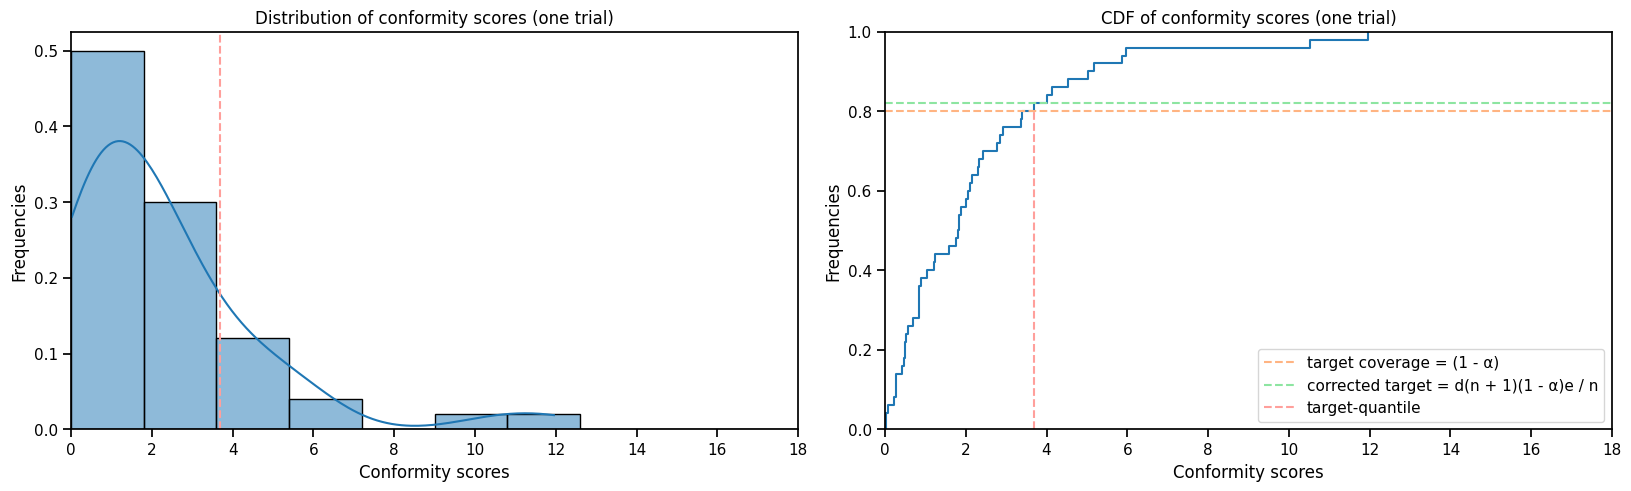

In [7]:
from utils.plot import plot_conformity_score_distribution

# Get the empirical conformity scores distribution (based on the calibration set)
conformity_scores = mapie_regressor.conformity_scores_.flatten()

# Plot its empirical distribution and its empirical cumulative distribution function (ECDF)
kwargs_hist = {'bins': 10, 'binrange': [0, 18]}
kwargs_ecdf = {}
plot_conformity_score_distribution(
    conformity_scores, quantile, alpha, alpha_cor,
    figsize=LARGE_FIGSIZE, kwargs_hist=kwargs_hist, kwargs_ecdf=kwargs_ecdf
)


### 5) Visualise the relationship between predictions and labels, as well as the size of prediction sets

Effective coverage score: 0.84
Set size score: 7.36


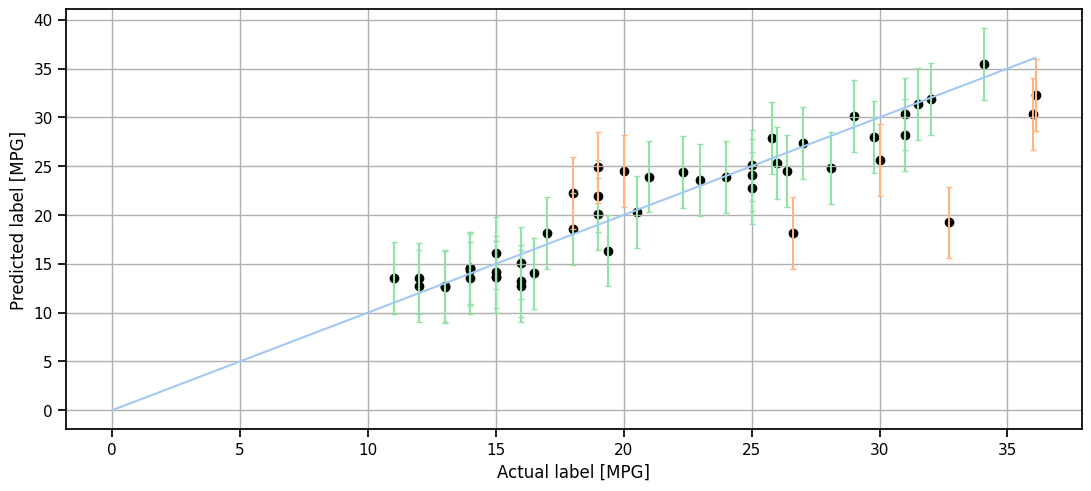

In [8]:
from utils.data.auto_mpg import plot_predictions, transform_set_to_label, get_yerr
from mapie.metrics import regression_coverage_score_v2, regression_mean_width_score

# Get the prediction sets and the prediction labels given the seleted alpha
df_final = deepcopy(df_valid)
df_final[PREDICTION] = y_pred
df_final[SET_LABEL] = transform_set_to_label(y_pis[:,:,alpha_idx])
df_final[SET] = list([elt for elt in y_pis[:,:,alpha_idx]])

y_err_down, y_err_up = get_yerr(y_pred, y_pis[:,:,alpha_idx])
df_final["error_down"] = y_err_down
df_final["error_up"] = y_err_up

# Compute the effective coverage score and the set size score
effective_coverage_score = regression_coverage_score_v2(np.array(y_valid), y_pis[:,:,alpha_idx])[0]
set_size_score = regression_mean_width_score(y_pis[:,0,alpha_idx], y_pis[:,1,alpha_idx])
print(f'Effective coverage score: {np.round(effective_coverage_score, 2)}')
print(f'Set size score: {np.round(set_size_score, 2)}')

# Plot the prediction sets, the prediction labels vs the true labels
plot_predictions(df_final, copy(mapie_regressor), alpha, figsize=MEDIUM_FIGSIZE)

### 6) Visualise the empirical distribution of prediction sets sizes

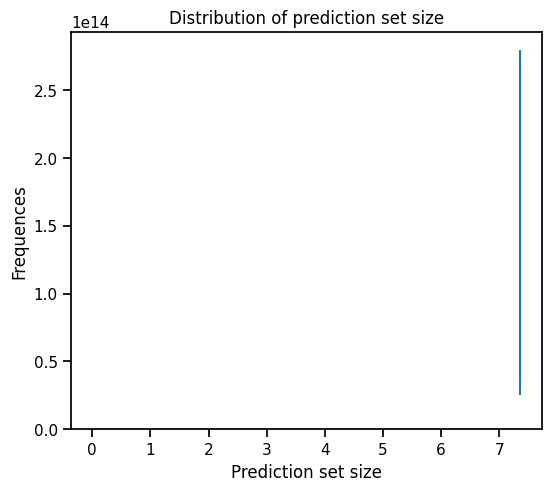

In [9]:
from utils.plot import plot_size_set_distribution

# Get the size of the prediction sets for each test sample
size_sets = y_pis[:,1,alpha_idx]-y_pis[:,0,alpha_idx]

# Plot the empirical distribution of the size of the prediction sets
kwargs = {'bins': 10, 'binrange': [0, np.max(size_sets)], 'kde': True}
plot_size_set_distribution(size_sets, label=LABEL, figsize=SMALL_FIGSIZE, **kwargs)

### 7) Visualise the impact of the choice of risk level (and confidence level) on effective coverage and average prediction set size

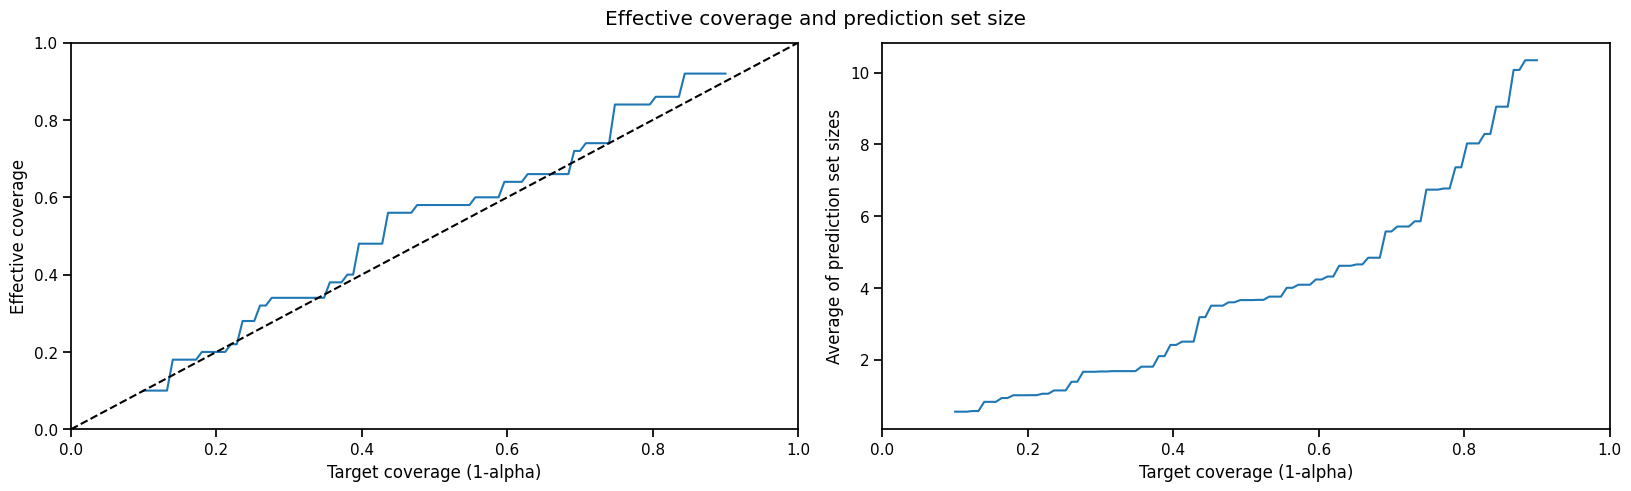

In [10]:
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from utils.plot import plot_conformal_metric_distribution

# Compute the effective coverage score and the set size score for each alpha
target_coverage_scores = 1-alpha_list
effective_coverage_scores = [
    [regression_coverage_score(np.array(y_valid), y_pis[:,0,i], y_pis[:,1,i]) for i in range(len(alpha_list))]
]
set_size_scores = [
    [regression_mean_width_score(y_pis[:,0,i], y_pis[:,1,i]) for i in range(len(alpha_list))]
]

# Plot the effective coverage score and the set size score for each alpha
plot_conformal_metric_distribution(
    target_coverage_scores, effective_coverage_scores, set_size_scores,
    nb_calib, nb_valid, figsize=LARGE_FIGSIZE
)

### 8) Visualise the empirical distribution of effective coverage

And see that the marginal coverage guarantee is valid in MAPIE. To do this:
- we will simulate different experiments using different train/calib/valid data splits and calculate the effective coverage score for each experiment.
- then we will visualize the empirical distribution of the effective coverage scores.
- the marginal coverage guarantee is valid if the average is higher than the target coverage.

In [11]:
# Just a few utility functions to vectorise the calculation with numpy
from sklearn.metrics import mean_absolute_error
from mapie.metrics import regression_coverage_score_v2, regression_mean_width_score


@np.vectorize()
def vec_idx2lab(elt):
    return 'all' if 0==elt else elt

@np.vectorize(signature='(p),(),(),(m)->(l)')
def vec_get_group(X, y_true_, y_pred_, y_pred_set_):
    return np.array([True] + [i*10<=y_true_<(i+1)*10 for i in range(1, 4)])

@np.vectorize(signature='(n,p),(n),(n),(n,m),(n)->()')
def vec_coverage_score(X, y_true_, y_pred_, y_pred_set_, mask=None):
    return regression_coverage_score_v2(y_true_[mask], y_pred_set_[mask])

@np.vectorize(signature='(n,p),(n),(n),(n,m),(n)->()')
def vec_set_size(X, y_true_, y_pred_, y_pred_set_, mask=None):
    return regression_mean_width_score(y_pred_set_[mask,0], y_pred_set_[mask,1])

@np.vectorize(signature='(n,p),(n),(n),(n,m),(n)->()')
def vec_accuracy_score(X, y_true_, y_pred_, y_pred_set_, mask=None):
    return mean_absolute_error(y_true_[mask], y_pred_[mask])

Here we configure our simulations by choosing their number and the parameters to be sent to the MAPIE class.

In [12]:
from utils.routine.multiple import get_prediction_on_several_trials

# Parameters of the modelisation
num_splits = 1000

kwargs_experiment = {
    'predictor': RandomForestRegressor,
    'conformalizer': MapieRegressor,
    'dataset': dataset,
    'delta': 1-alpha,
    'nb_train': nb_train,
    'nb_calib': nb_calib,
    'nb_test': nb_valid,
    'sample_and_split_function': sample_and_split_dataset,
    'get_dataframe': get_dataframe,
    'get_X_y': get_X_y,
    'kwargs_predictor': kwargs_predictor,
    'kwargs_conformalizer': kwargs_conformalizer,
    'kwargs_predict': kwargs_predict,
    'random_state': None,
}

metric_fcts={
    'coverage': vec_coverage_score,
    'set_size': vec_set_size,
    'performance': vec_accuracy_score
}

# Get the prediction sets for several trials
df_all_results = get_prediction_on_several_trials(
    kwargs_experiment,
    num_splits=num_splits,
    group_fct=vec_get_group,
    label_fct=vec_idx2lab,
    metric_fcts=metric_fcts,
    exp_name='absolute',
)

# Get the empirical coverage score for each trial
empirical_coverages_mapie = df_all_results[df_all_results['group']=='all']['coverage'].to_numpy()

We plot the empirical distribution of the effective coverage scores. Notice that the effective coverage follows a beta distribution arount the target coverage, which depends on the number of calibration data and the number of validation data.

See more details in the paper *Angelopoulos, A. N., & Bates, S. (2023). Conformal prediction: A gentle introduction. Foundations and Trends® in Machine Learning, 16(4), 494-591.*.

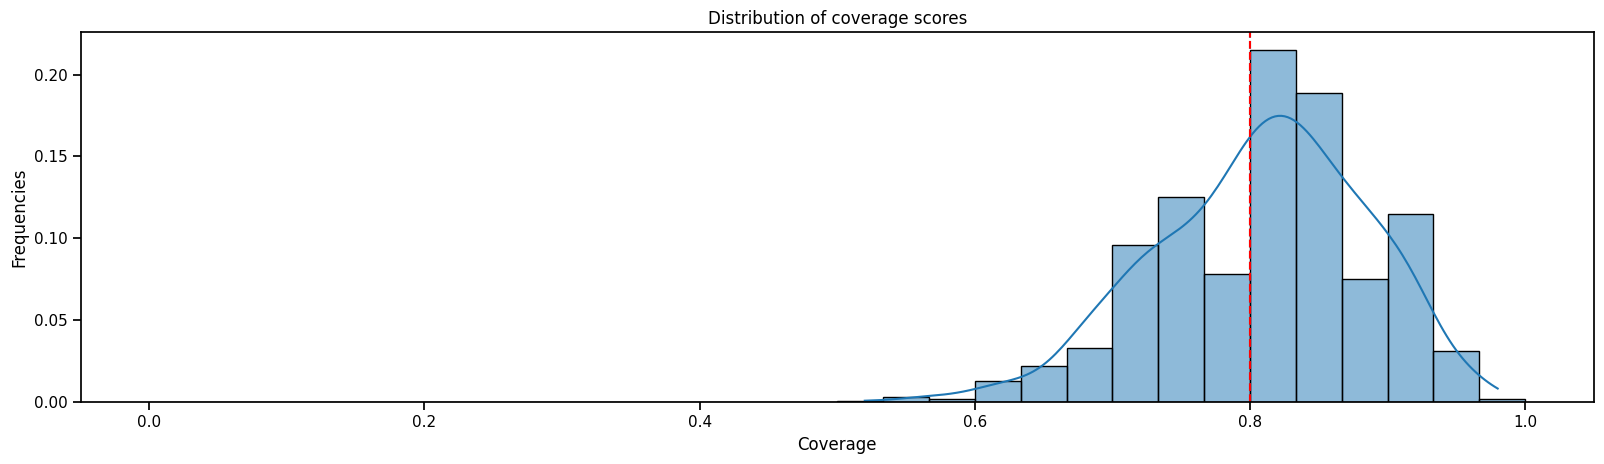

In [13]:
from utils.routine.single import plot_empirical_coverage_convergence

# Plot the empirical coverage score distribution (histogram) for the selected alpha
plot_empirical_coverage_convergence(
    empirical_coverages_mapie,
    1-alpha, nb_calib=nb_calib, nb_val=nb_valid,
    figsize=LARGE_FIGSIZE,
    only_distribution=True,
)